In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

/home/martyn/anaconda3/envs/DataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
tf.__version__

'2.2.0'

In [3]:
myMinMaxScaler = MinMaxScaler()

In [4]:
import_df = pd.read_csv('20171021_20171124_1min.csv', index_col = 0, date_parser = pd.to_datetime)
import_df

,open,high,low,close,average
timestamp,,,,,
2017-10-21 00:00:00+00:00,6018.7,6022.1,6011.0,6020.0,6016.795301
2017-10-21 00:01:00+00:00,6019.9,6020.0,6014.2,6014.3,6018.435888
2017-10-21 00:02:00+00:00,6014.3,6016.6,6012.1,6012.1,6014.576291
2017-10-21 00:03:00+00:00,6012.1,6014.2,6012.1,6013.0,6012.818012
2017-10-21 00:04:00+00:00,6012.9,6018.0,6012.8,6015.8,6017.010478
...,...,...,...,...,...
2017-11-24 23:55:00+00:00,8221.0,8221.0,8220.5,8221.0,8220.783234
2017-11-24 23:56:00+00:00,8221.0,8222.5,8218.0,8218.0,8220.265747
2017-11-24 23:57:00+00:00,8218.0,8218.0,8211.0,8211.5,8213.875742


In [5]:
import_df = import_df.dropna()

# Train / Test Split

In [6]:
import_df.shape

(50351, 5)

In [7]:
test_size = int(import_df.shape[0] / 3)
train_size = import_df.shape[0] - test_size
train_size

33568

In [8]:
train_df = import_df[:train_size]
# train_df = myMinMaxScaler.fit_transform(train_df)
test_df = import_df[train_size:]
# test_df = myMinMaxScaler.transform(test_df)

# TS Analysis

In [11]:
train_y_orig = train_df.close

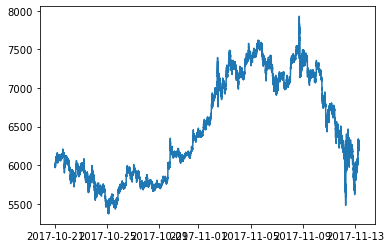

In [12]:
plt.plot(train_y_orig)

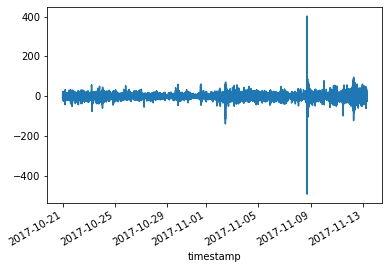

In [13]:
train_y_1dif = (train_y_orig - train_y_orig.shift(1)).dropna()
train_y_1dif.plot();

In [14]:
adfuller(train_y_1dif)

(-25.059235947356274,
 0.0,
 52,
 33514,
 {'1%': -3.430545136388853,
  '5%': -2.861626245341377,
  '10%': -2.5668159057055475},
 254646.5223760657)

p-value is 0, therefore reject that the series has unit root, aka series is stationary.

# LSTM


In [76]:
window_size = 60
look_ahead = 1
y_train = np.array(train_df.close[window_size + look_ahead:])
# y_train = np.array(train_df[window_size + look_ahead:, 3])
data_points_train = y_train.shape[0]
data_points_train
y_test = np.array(test_df.close[window_size + look_ahead:])
# y_test = np.array(test_df[window_size + look_ahead:, 3])
data_points_test = y_test.shape[0]
data_points_train, data_points_test

(33507, 16722)

In [66]:
X_train = np.zeros((data_points_train, window_size, 5))
X_test = np.zeros((data_points_test, window_size, 5))

In [67]:
for i in range(data_points_train):
#     X_train[i] = train_df[:window_size,:]
    X_train[i] = train_df.iloc[:window_size,].values
for i in range(data_points_test):   
    X_test[i] = test_df.iloc[:window_size,].values
#     X_test[i] = test_df[:window_size,:]

In [68]:
train_data_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
BATCH_SIZE = 1
BUFFER_SIZE = 10000
train_data_tf = train_data_tf.cache().batch(BATCH_SIZE).repeat()

In [69]:
test_data_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))
BATCH_SIZE = 1
BUFFER_SIZE = 10000
test_data_tf = test_data_tf.cache().batch(BATCH_SIZE).repeat()

In [78]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=X_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='tanh'))

multi_step_model.add(tf.keras.layers.Dense(1))



In [79]:
multi_step_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 60, 32)            4864      
_________________________________________________________________
lstm_40 (LSTM)               (None, 60, 32)            8320      
_________________________________________________________________
lstm_41 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________


In [80]:
for x, y in train_data_tf.take(1):
    print (multi_step_model.predict(x).shape)
    print(multi_step_model.predict(x))

(1, 1)
[[-0.2880546]]


In [81]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)

In [86]:
# multi_step_model.compile(optimizer=opt, loss='mse')
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0, lr=0.1), loss='mae')
# multi_step_model.compile(optimizer='adam', loss='mse')

In [88]:
EVALUATION_INTERVAL = 5_000
EPOCHS = 10



multi_step_history = multi_step_model.fit(train_data_tf, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=test_data_tf,
                                          validation_steps=200)


Epoch 1/10
  54/5000 [..............................] - ETA: 4:16 - loss: 1949.3912

KeyboardInterrupt: 

In [25]:
STEP = 1
def create_time_steps(length):
      return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = 1

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


In [26]:
# dir(multi_step_model)
# dir(multi_step_model.weights[0][0])
# # multi_step_model.weights[1].numpy().min()
# len(multi_step_model.weights)
# for i in range(8):
#     print(multi_step_model.weights[i].numpy().min())
# multi_step_model.weights

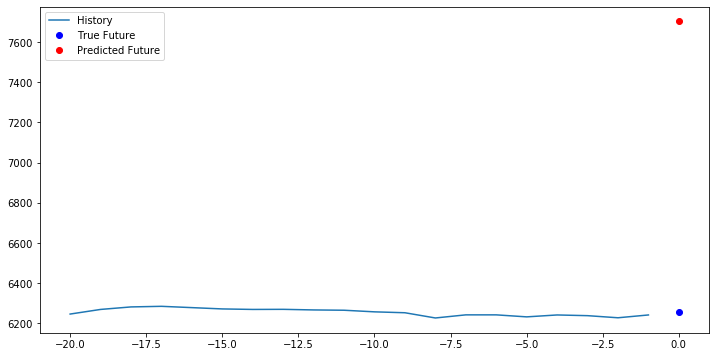

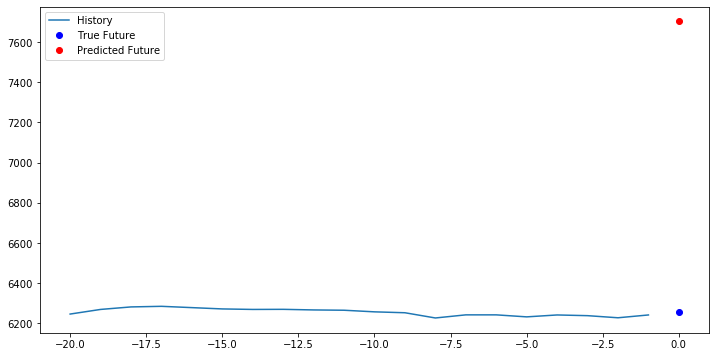

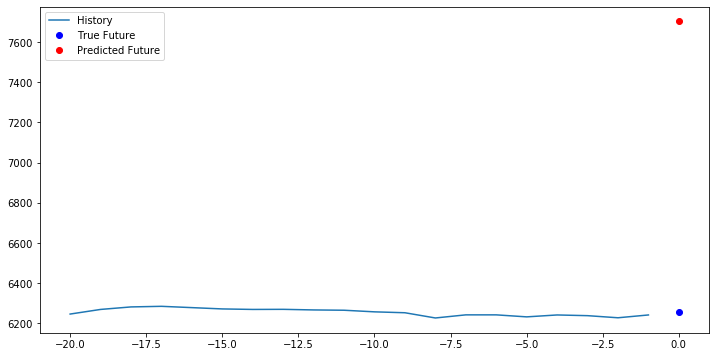

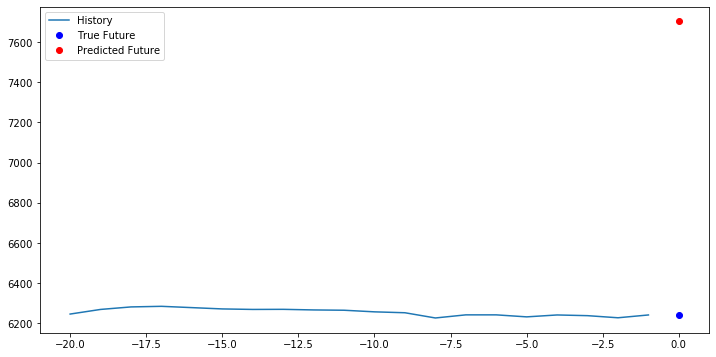

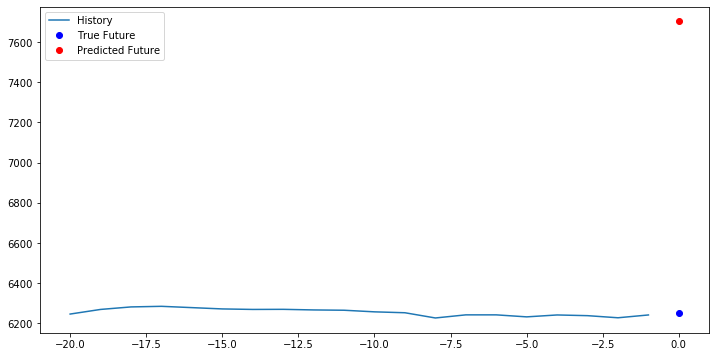

In [64]:
for x, y in test_data_tf.take(5):
      multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0]);

In [28]:
for x, y in test_data_tf.take(1):
  print(multi_step_model.predict(x))

[[1998.759]]
